In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rnd

In [2]:
from datetime import datetime
import os
import pathlib

t = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
log_dir = "tf_logs"
logd = "/tmp/{}/r{}/".format(log_dir, t)

# Then every time you have specified a graph run:
# file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Make directory if it doesn't exist

from pathlib import Path
home = str(Path.home())

logdir = os.path.join(os.sep,home,logd)

if not os.path.exists(logdir):
    os.makedirs(logdir)

part 1

In [3]:
digits= load_digits()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model

def compute_model_accuracy(model, X_train, Y_train):
    kf = StratifiedKFold(n_splits=3, random_state = 0)
    validation_accuracy = []
    
    for train_idx, valid_idx in kf.split(X_train, Y_train):
        # split the data
        split_X_train, split_X_valid = X_train[train_idx, :], X_train[valid_idx, :]
        split_Y_train, split_Y_valid = Y_train[train_idx], Y_train[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the accuracy on the validation split
        accuracy = model.score(split_X_valid, split_Y_valid)
        validation_accuracy.append(accuracy)
        
    return np.mean(validation_accuracy)

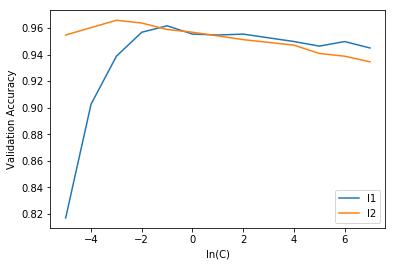

In [4]:
validation_accuracy_l1 = []
validation_accuracy_l2 = []
C = []
for i in range(13):
    c = np.exp(i-6)
    C.append(i-5)
    LogisticModel = linear_model.LogisticRegression(penalty = 'l1', C = c)
    validation_accuracy_l1.append(compute_model_accuracy(LogisticModel, x_train, y_train))

C = []
for i in range(13):
    c = np.exp(i-6)
    C.append(i-5)
    LogisticModel = linear_model.LogisticRegression(penalty = 'l2', C = c)
    validation_accuracy_l2.append(compute_model_accuracy(LogisticModel, x_train, y_train))
plt.plot(C, validation_accuracy_l1, label = 'l1')
plt.plot(C, validation_accuracy_l2, label = 'l2')
plt.legend()
plt.xlabel('ln(C)')
plt.ylabel('Validation Accuracy')
plt.show()

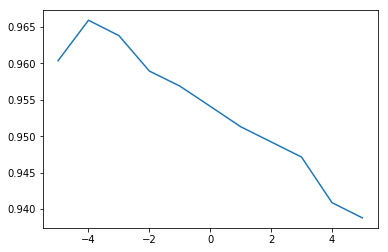

In [5]:
validation_accuracy = []
C = []
for i in range(11):
    c = np.exp(i-5)
    C.append(i-5)
    LogisticModel = linear_model.LogisticRegression(penalty = 'l2', C = c)
    validation_accuracy.append(compute_model_accuracy(LogisticModel, x_train, y_train))
plt.plot(C, validation_accuracy)
plt.show()

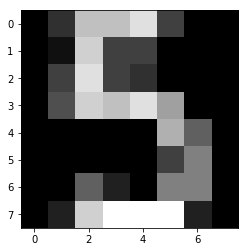

In [6]:
plt.imshow(np.reshape(x_train[1], (8,8)), cmap=plt.cm.gray)
plt.show()

Part 2

1. Multiclass Logistic Regression Model

In [34]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [35]:
# processing the target
a = pd.DataFrame(columns = range(10))
a['cat'] = y_train
a = a.fillna(0)
for idx, row in a.iterrows():
    for i in range(10):
        if row['cat'] == i:
            row[i] = 1
y_train = np.array(a.drop('cat', axis = 1))

a = pd.DataFrame(columns = range(10))
a['cat'] = y_test
a = a.fillna(0)
for idx, row in a.iterrows():
    for i in range(10):
        if row['cat'] == i:
            row[i] = 1
y_test = np.array(a.drop('cat', axis = 1))

In [36]:
# construction
tf.reset_default_graph()

In [51]:
size = x_train.shape[1]
# Define input
x = tf.placeholder(tf.float32,shape = [None,size], name="x") 
y = tf.placeholder(tf.float32, shape = [None, 10], name="y")

# Define weights and bias
W = tf.Variable(tf.zeros([size, 10]), name = 'weights') # number of weights
b = tf.Variable(tf.zeros([10]), name = 'bias') # number of bias terms

In [52]:
# model
y_hat = tf.nn.softmax(tf.matmul(x, W) + b) 

# loss function
loss = tf.reduce_mean(-tf.reduce_sum( y* tf.log(y_hat),axis=1))

# train
learning_rate = 0.001
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [53]:
# monitor accuracy    
with tf.name_scope("eval"):
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_hat,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [65]:
# execution
init = tf.global_variables_initializer()
n_epochs = 200
batch_size = 100
num_batches = x_train.shape[0] // batch_size

acc_train1 = []
acc_val1 = []
with tf.Session() as sess:
    writer = tf.summary.FileWriter("logs/", graph = tf.get_default_graph())
    init.run()
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(x_train)) 
        x_batches = np.array_split(x_train[shuffled_idx], num_batches)
        y_batches = np.array_split(y_train[shuffled_idx], num_batches)
        for x_batch, y_batch in zip(x_batches, y_batches):
            sess.run(train_step, feed_dict={x: x_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={x: x_batch, y: y_batch})
        acc_train1.append(acc_train)
        tf.summary.scalar('training_accuracy', acc_train)
        acc_val = accuracy.eval(feed_dict={x: x_test, y: y_test})
        acc_val1.append(acc_val)
        tf.summary.scalar('validation_accuracy', acc_val)
        merged_summary = tf.summary.merge_all()
        s = sess.run(merged_summary)
        writer.add_summary(s, epoch)
        
show_graph(tf.get_default_graph())

InvalidArgumentError: You must feed a value for placeholder tensor 'x_1' with dtype float
	 [[Node: x_1 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'x_1', defined at:
  File "/Users/rhett/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/rhett/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-51-3fcfd5eff410>", line 3, in <module>
    x = tf.placeholder(tf.float32,shape = [None,size], name="x")
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1507, in placeholder
    name=name)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1997, in _placeholder
    name=name)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/rhett/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'x_1' with dtype float
	 [[Node: x_1 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [64]:
a = tf.summary.scalar('training_accuracy', accuracy)
a

<tf.Tensor 'training_accuracy_1008:0' shape=() dtype=string>

In [62]:
accuracy

<tf.Tensor 'eval_1/Mean:0' shape=() dtype=float32>

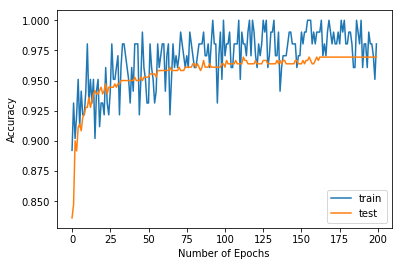

In [14]:
plt.plot(np.arange(n_epochs), acc_train1, label = 'train')
plt.plot(np.arange(n_epochs), acc_val1, label = 'test')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show()

$2$. Vanilla Dense Neural Network

In [15]:
# dnn with 3 hidden layer
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)
n_inputs = 8*8  # MNIST
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 10

In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
prob = tf.placeholder(tf.float32, name = 'prob')

In [17]:
def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # Output from every neuron
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [18]:
# prob = tf.placeholder(tf.float32, name = 'prob')
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.tanh)
    dropout1 = tf.nn.dropout(x = hidden1, keep_prob = prob)
    hidden2 = neuron_layer(dropout1, n_hidden2, name="hidden2", activation=tf.nn.tanh)
    dropout2 = tf.nn.dropout(x = hidden2, keep_prob = prob)
    hidden3 = neuron_layer(dropout2, n_hidden3, name="hidden3", activation=tf.nn.tanh)
    dropout3 = tf.nn.dropout(x = hidden3, keep_prob = prob)
    logits = neuron_layer(dropout3, n_outputs, name="outputs")

In [19]:
# Define loss function (that also optimizes Softmax for output):

with tf.name_scope("loss"):
    # logits are from the last output of the dnn 
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [20]:
# Training step with Gradient Descent
learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [21]:
# Evaluation to see accuracy

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [22]:
init = tf.global_variables_initializer()

n_epochs = 1000
batch_size = 100
num_batches = x_train.shape[0] // batch_size

acc_train2 = []
acc_val2 = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(x_train)) 
        x_batches = np.array_split(x_train[shuffled_idx], num_batches)
        y_batches = np.array_split(y_train[shuffled_idx], num_batches)
        for x_batch, y_batch in zip(x_batches, y_batches):
            sess.run(training_op, feed_dict={X: x_batch, y: y_batch, prob: 0.9})
        acc_train2.append(accuracy.eval(feed_dict={X: x_batch, y: y_batch, prob: 1.0}))
        acc_val2.append(accuracy.eval(feed_dict={X: x_test, y: y_test, prob: 1.0}))
        
show_graph(tf.get_default_graph())


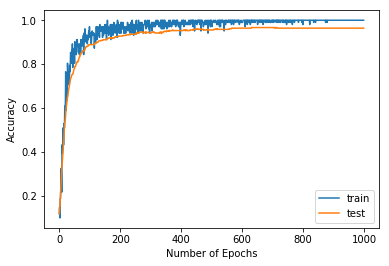

In [23]:
plt.plot(np.arange(n_epochs), acc_train2, label = 'train')
plt.plot(np.arange(n_epochs), acc_val2, label = 'test')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show()

In [24]:
max(acc_val2)

0.96666664

Part 3

1.

Neuron Saturation:

Neuron Saturation is a phenomenon that a neuron predominantly outputs values close to the asymptotic ends of the bounded activation function. For example, if you are using $\tanh()$ as activation function, the hidden nodes usually have values between -1 and +1. In this case, saturation refers to the situation where most of the hidden nodes have values close to -1 or +1. 
It would slow down the training process because saturated nodes lead to a situation where a small change in the input-to-hidden weights during training will likely not change the sum-of-products very much, and then after activation, the node value will still be -1 or +1.

Batch Normalization:

Batch Normalization is a method to reduce internal covariate shift in neural networks. One algorithm to implement it is the transformation of the original input of a layer $x$ to the shifted and normalized value $y$. In the algorithms, the value $\epsilon$ is inserted to avoid dividing by 0 and is selected to be insignificant small  on purpose.

The specification goes as follow: 
1. The scalar features are normalized independently, making their means to be 0 and the variance to be 1. This means in case of a d-dimensional input $x = \{x_1, \cdots x_d\}$, each dimension of the input $x$ is normalized independently, thus every variable $x$, $y$, $\mu$, $\sigma$ becomes $x_k$, $y_k$, $\mu_k$, $\sigma_k$.
2. Each mini-batch produces estimates of the mean and variance of each activation. This ensures that a batch-normalized network retains its ability to fully use backpropagation.

INPUT: Values of $x$ over a mini-batch: $B= \{x_1, \cdots, x_m\}$.

PARAMETER: $\gamma$, $\beta$.

OUTPUT: $\{y_i=BN_{\gamma, \beta}(x_i)\}$

$$
\mu_B=\frac{1}{m}\sum_{i = 1}^{m}x_i
$$
$$
\sigma_B^2 = \frac{1}{m}\sum_{i = 1}^{m}(x_i - \mu_B)^2
$$
$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$
$$
y_i = \gamma \hat{x}_i +\beta
$$

As a simple normalization of $x$ that may lead to a change of the representation of the affected layer, $y$ is introduced. The introduction of $y$ makes sure that the transformation represents an identity transform, meaning that x is fully substituted by y for every input. Thus $\gamma$ and $\beta$ are introduced as scale and shift parameters, which are to be learned besides the already existing parameters of the network. This increases the amount of parameters to be learned, but the BN compensations that with an increase regarding the learning speed and overall fewer processing steps. Note that $\gamma$ and $\beta$ also become $\gamma(k)$ and $\beta(k)$ in the case of d-dimensional input.

2.



Activiation function brings nonlinearity to the neural network. It defines the output of a node given the input. Activiation functions include logistic (sigmoid), tanh, Rectified linear unit(ReLU) and the like.

a. Sigmoid

Nonlinear. Towards either end of the sigmoid function, the Y values tend to respond very less to changes in X. The gradient at that region is going to be small, which gives rise to a problem of “vanishing gradients”. 
$$
f(x) = \frac{1}{1+e^{-x}}
$$

$$
f'(x) = f(x)(1-f(x))
$$

b. Tanh

Nonlinear. Gradient is stronger than the sigmoid function. "Vanishing gradients".
$$
f(x) = \tanh(x) = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}
$$

$$
f'(x) = 1-f(x)^2
$$

c. ReLU

Linear in positive axis. Gradient can go 0.
$$
f(x)=\left\{
\begin{aligned}
0 &  &x< 0 \\
x &  &x\ge 0
\end{aligned}
\right.
$$

$$
f'(x) = \left\{
\begin{aligned}
0 &  &x< 0 \\
1 &  &x\ge 0
\end{aligned}
\right.
$$

3.

In [25]:
# dnn with 3 hidden layer
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)
n_inputs = 8*8  # MNIST
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 10

In [26]:
def neuron_layer_BN(X, n_neurons, name, activation=None, epsilon = 1e-3):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function

    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # Output from every neuron
        Z = tf.matmul(X, W) + b
        
        # Batch normalization
        batch_mean, batch_var = tf.nn.moments(Z,[0])
        scale = tf.Variable(tf.ones(n_neurons))
        beta = tf.Variable(tf.zeros(n_neurons))
        BN = tf.nn.batch_normalization(Z,batch_mean,batch_var,beta,scale,epsilon)
        
        if activation is not None:
            return activation(BN)
        else:
            return BN

In [27]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
prob = tf.placeholder(tf.float32, name = 'prob')

with tf.name_scope("dnn"):
    hidden1 = neuron_layer_BN(X, n_hidden1, name="hidden1", activation=tf.nn.tanh)
    dropout1 = tf.nn.dropout(x = hidden1, keep_prob = prob)
    hidden2 = neuron_layer_BN(dropout1, n_hidden2, name="hidden2", activation=tf.nn.tanh)
    dropout2 = tf.nn.dropout(x = hidden2, keep_prob = prob)
    hidden3 = neuron_layer_BN(dropout2, n_hidden3, name="hidden3", activation=tf.nn.tanh)
    dropout3 = tf.nn.dropout(x = hidden3, keep_prob = prob)
    logits = neuron_layer(dropout3, n_outputs, name="outputs")

In [28]:
# Define loss function (that also optimizes Softmax for output):

with tf.name_scope("loss"):
    # logits are from the last output of the dnn 
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
# Training step with Gradient Descent
learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
# Evaluation to see accuracy

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [29]:
init = tf.global_variables_initializer()

n_epochs = 1000
batch_size = 100
num_batches = x_train.shape[0] // batch_size

acc_train3 = []
acc_val3 = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(x_train)) 
        x_batches = np.array_split(x_train[shuffled_idx], num_batches)
        y_batches = np.array_split(y_train[shuffled_idx], num_batches)
        for x_batch, y_batch in zip(x_batches, y_batches):
            sess.run(training_op, feed_dict={X: x_batch, y: y_batch, prob: 0.9})
        acc_train3.append(accuracy.eval(feed_dict={X: x_batch, y: y_batch, prob: 1.0}))
        acc_val3.append(accuracy.eval(feed_dict={X: x_test, y: y_test, prob: 1.0}))

show_graph(tf.get_default_graph())

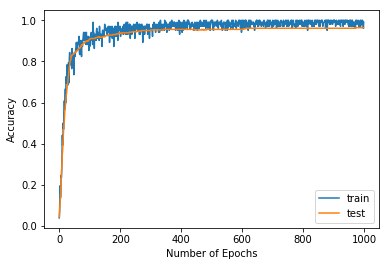

In [30]:
plt.plot(np.arange(n_epochs), acc_train3, label = 'train')
plt.plot(np.arange(n_epochs), acc_val3, label = 'test')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show()

In [31]:
max(acc_val3)

0.96388888

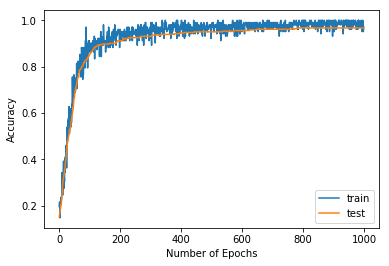

0.96666664

In [32]:
# dnn with 3 hidden layer
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)
n_inputs = 8*8  # MNIST
n_hidden1 = 200
n_hidden2 = 100
n_outputs = 10

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
prob = tf.placeholder(tf.float32, name = 'prob')

with tf.name_scope("dnn"):
    hidden1 = neuron_layer_BN(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    dropout1 = tf.nn.dropout(x = hidden1, keep_prob = prob)
    hidden2 = neuron_layer_BN(dropout1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    dropout2 = tf.nn.dropout(x = hidden2, keep_prob = prob)
    logits = neuron_layer(dropout2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    # logits are from the last output of the dnn 
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
# Training step with Gradient Descent
learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
# Evaluation to see accuracy

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

n_epochs = 1000
batch_size = 100
num_batches = x_train.shape[0] // batch_size

acc_train4 = []
acc_val4 = []
loss_train = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(x_train)) 
        x_batches = np.array_split(x_train[shuffled_idx], num_batches)
        y_batches = np.array_split(y_train[shuffled_idx], num_batches)
        for x_batch, y_batch in zip(x_batches, y_batches):
            sess.run(training_op, feed_dict={X: x_batch, y: y_batch, prob: 0.9})
        acc_train4.append(accuracy.eval(feed_dict={X: x_batch, y: y_batch, prob: 1.0}))
        acc_val4.append(accuracy.eval(feed_dict={X: x_test, y: y_test, prob: 1.0}))
        loss_train.append(loss.eval(feed_dict={X: x_batch, y: y_batch, prob: 1.0}))
        

show_graph(tf.get_default_graph())

plt.plot(np.arange(n_epochs), acc_train4, label = 'train')
plt.plot(np.arange(n_epochs), acc_val4, label = 'test')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show()

max(acc_val4)

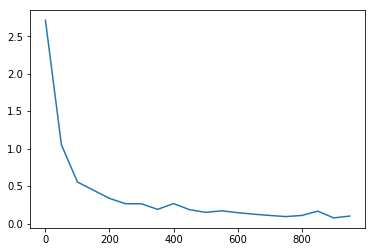

In [33]:
plt.plot(np.arange(0, n_epochs, 50), loss_train[::50], label = 'loss')
plt.show()